# first attempts at autogluon

our first attempt is just to get an idea of how autogluon works. we'll be doing a relatively simple prediction: given the daily frequency of crimes for a time period, predict future daily crime frequencies. namely, given the daily frequence of crimes for the previous few months, predict the next week's daily crime frequencies.

In [3]:
import pandas as pd
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

we read `crime.csv`, montgomery county's crime data, and group all the crimes that were committed in one day together. we remember to filter out data with no dates attached to them, and also get rid the columns we don't need, which amounts to almost every single one of them. this is because autogluon, at its most basic level, only needs the series name, the timestamps, and the the values of the series.

In [5]:
df = pd.read_csv("../moco_crime.csv")
df = df[df['Start_Date_Time'] != '']
df['Start_Date_Time'] = df['Start_Date_Time'].str[:10]
df['target'] = 1
df = df[df.columns.intersection(['Start_Date_Time','target'])]

/tmp/ipykernel_69151/325919613.py:1: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../moco_crime.csv")


then, we group all the crimes committed by the day they were committed on, and sum them to find the daily frequency.

In [6]:
df = df.groupby(['Start_Date_Time'],sort=False,as_index=False).sum()
df['crime'] = 'Crimes'
df['Start_Date_Time'] = pd.to_datetime(df['Start_Date_Time'])
# df = df[df['Start_Date_Time'] >= pd.to_datetime('2022-01-01')]
df = df[df['Start_Date_Time'] <= pd.to_datetime('2023-01-01')]
df = df.sort_values(by='Start_Date_Time')
df.tail()

,Start_Date_Time,target,crime
1532,2022-12-28,130,Crimes
1316,2022-12-29,137,Crimes
1322,2022-12-30,138,Crimes
1347,2022-12-31,108,Crimes
1567,2023-01-01,125,Crimes


we establish covariants: checking if each day is a weekend or holiday. the reasoning goes, business days should be treated differently because of the differences in behavior between working and nonworking days. this gets put in a `known_covariates` dataframe.

In [7]:
from scipy import stats
from pandas.tseries.holiday import USFederalHolidayCalendar

known_covariates_per_item = pd.DataFrame()
df['bc_target'] = stats.boxcox(df['target'])[0]
known_covariates_per_item['weekend'] = df['Start_Date_Time'].dt.dayofweek // 5
holidays = USFederalHolidayCalendar().holidays(start='2015-01-01', end='2023-01-31').to_pydatetime()
known_covariates_per_item['holiday'] = [1 if d in holidays else 0 for d in df['Start_Date_Time']]
known_covariates_per_item['timestamp'] = df['Start_Date_Time']
known_covariates_per_item['item_id'] = 'Crimes'
known_covariates = TimeSeriesDataFrame(known_covariates_per_item)
known_covariates.head()

weekend  holiday
item_id timestamp                   
Crimes  2016-07-01        0        0
        2016-07-02        1        0
        2016-07-03        1        0
        2016-07-04        0        1
        2016-07-05        0        0

we put our data into autogluon's dataframe.

In [8]:
train_data = TimeSeriesDataFrame.from_data_frame(df, id_column='crime', timestamp_column='Start_Date_Time')
train_data.head()

target  bc_target
item_id timestamp                    
Crimes  2016-07-01     243  40.962081
        2016-07-02     175  33.494902
        2016-07-03     152  30.704962
        2016-07-04     125  27.195350
        2016-07-05     167  32.542749

training for a prediction length of 60 days. 

In [12]:
predictor = TimeSeriesPredictor(
    prediction_length = 60, 
    path = './basic_total_crimes', 
    target = 'target',
    known_covariates=known_covariates, 
    eval_metric = 'sMAPE',
)
predictor.fit(train_data, num_cpus=16, num_gpus=4, presets='best_quality')

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: best_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'sMAPE',
 'hyperparameter_tune_kwargs': {'num_trials': 10,
                                'scheduler': 'local',
                                'searcher': 'auto'},
 'hyperparameters': 'best_quality',
 'num_cpus': 16,
 'num_gpus': 4,
 'prediction_length': 60,
 'random_seed': None,
 'target': 'target',
 'time_limit': None}
Provided training data set with 2376 rows, 1 items (item = single time series). Average time series length is 2376.0.
Training artifacts will be saved to: /fs/cml-projects/teamgahsp/gahsp/basic_total_crimes
AutoGluon will save models to ./basic_total_crimes/
AutoGluon will gauge predictive performance using evaluation metric: 'sMAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Pr

  0%|          | 0/10 [00:00<?, ?it/s]

Stopping HPO due to exhausted search space: 2 of 2 possible configs ran.
	Trained 2 models while tuning Theta.
	-0.1397       = Validation score (-sMAPE)
	11.10   s     = Total tuning time
Hyperparameter tuning model: ARIMA. 
	-0.1393       = Validation score (-sMAPE)
	0.00    s     = Training runtime
	5.52    s     = Validation (prediction) runtime
Hyperparameter tuning model: AutoETS. 
	-0.1396       = Validation score (-sMAPE)
	0.00    s     = Training runtime
	26.89   s     = Validation (prediction) runtime
Hyperparameter tuning model: DynamicOptimizedTheta. 
	-0.1345       = Validation score (-sMAPE)
	0.00    s     = Training runtime
	12.29   s     = Validation (prediction) runtime
Hyperparameter tuning model: DeepAR. 


  0%|          | 0/10 [00:00<?, ?it/s]

	Trained 10 models while tuning DeepAR.
	-0.1218       = Validation score (-sMAPE)
	838.38  s     = Total tuning time
Hyperparameter tuning model: AutoARIMA. 
	-0.1403       = Validation score (-sMAPE)
	0.00    s     = Training runtime
	11.40   s     = Validation (prediction) runtime
Hyperparameter tuning model: TemporalFusionTransformer. 
	-0.1162       = Validation score (-sMAPE)
	267.72  s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Hyperparameter tuning model: SimpleFeedForward. 


  0%|          | 0/10 [00:00<?, ?it/s]

Stopping HPO due to exhausted search space: 3 of 3 possible configs ran.
	Trained 3 models while tuning SimpleFeedForward.
	-0.1242       = Validation score (-sMAPE)
	156.29  s     = Total tuning time
Fitting simple weighted ensemble.
	-0.1146       = Validation score (-sMAPE)
	7.97    s     = Training runtime
	0.25    s     = Validation (prediction) runtime
Training complete. Models trained: ['Naive', 'SeasonalNaive', 'ETS', 'Theta/T1', 'Theta/T2', 'ARIMA', 'AutoETS', 'DynamicOptimizedTheta', 'DeepAR/T1', 'DeepAR/T2', 'DeepAR/T3', 'DeepAR/T4', 'DeepAR/T5', 'DeepAR/T6', 'DeepAR/T7', 'DeepAR/T8', 'DeepAR/T9', 'DeepAR/T10', 'AutoARIMA', 'TemporalFusionTransformer', 'SimpleFeedForward/T1', 'SimpleFeedForward/T2', 'SimpleFeedForward/T3', 'WeightedEnsemble']
Total runtime: 1362.15 s
Best model: WeightedEnsemble
Best model score: -0.1146


we create a plot of predicted vs. actual crime frequencies.

[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
/tmp/ipykernel_69151/3872456995.py:6: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("../moco_crime.csv")


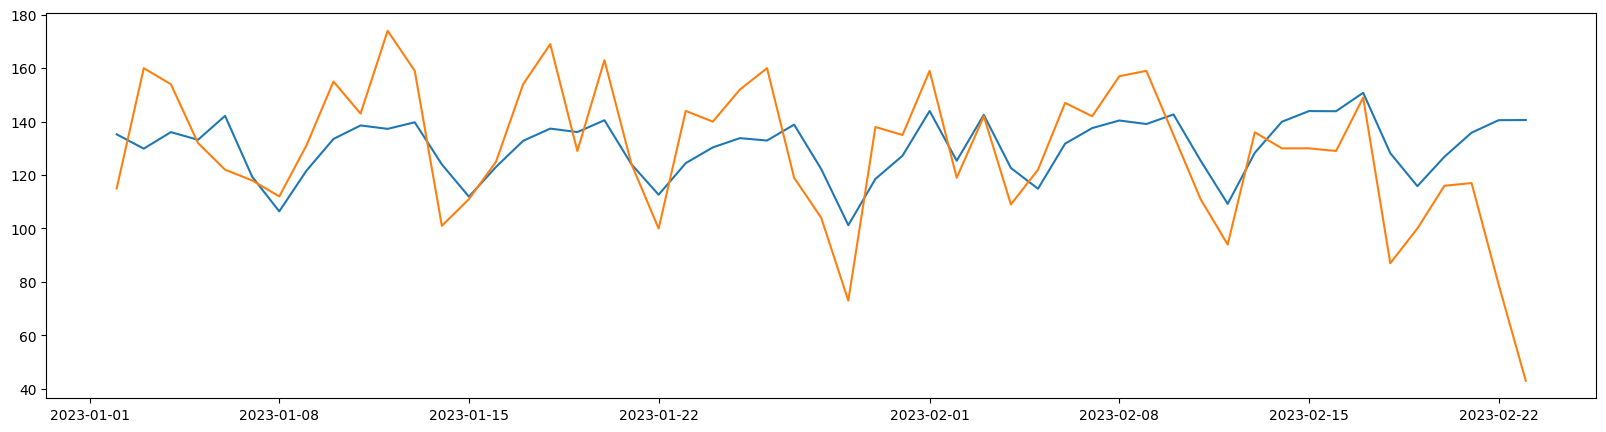

In [31]:
import matplotlib.pyplot as plt

predictions = predictor.predict(train_data)
predictions.head()

test_data = pd.read_csv("../moco_crime.csv")
test_data = test_data[test_data['Start_Date_Time'] != '']
test_data['Start_Date_Time'] = test_data['Start_Date_Time'].str[:10]
test_data['target'] = 1
test_data = test_data[test_data.columns.intersection(['Start_Date_Time','target'])]
test_data = test_data.groupby(['Start_Date_Time'],sort=False,as_index=False).sum()
test_data['crime'] = 'Crimes'
test_data['Start_Date_Time'] = pd.to_datetime(test_data['Start_Date_Time'])
test_data = test_data.sort_values(by='Start_Date_Time')
test_data = test_data[test_data['Start_Date_Time'] >= pd.to_datetime('2022-01-01')]
test_data = test_data[test_data['Start_Date_Time'] <= pd.to_datetime('2023-03-31')]
test_data = TimeSeriesDataFrame.from_data_frame(test_data, id_column='crime', timestamp_column='Start_Date_Time')

item_id = 'Crimes'
y_past = train_data.loc[item_id]['target']
y_pred = predictions.loc[item_id][:53]
y_test = test_data.loc[item_id]['target'][-53:]

plt.figure(figsize=(20, 5))

# plt.plot(y_past, label='Past time series values')
plt.plot(y_pred['mean'], label='Mean forecast')
plt.plot(y_test, label='Future time series values')
plt.savefig('moco_crime_initial_prediction.png')